In [1]:
from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/denoised_v3.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    init_features=["latitude", "longitude"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 17914
    File location: ../deep_traffic_generation/data/denoised_v3.pkl
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_4/checkpoints/epoch=299-step=3599.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_4/hparams.yaml",
    input_dim = dataset.input_dim,
    seq_len = dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [36]:
n_to_show = 20
data = model.decoder(torch.normal(0, 1, size=(n_to_show, model.hparams.encoding_dim)))
    
data = torch.transpose(data, 1, 2).detach().numpy()

data = data.reshape((data.shape[0], -1))
data = model.scaler.inverse_transform(data)

# add latitude longitude info
info = np.ones((n_to_show, 2)) * 40
data = np.concatenate((info, data), axis=1)

builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

(20, 800)


,count
flight_id,
0,200
1,200
8,200
7,200
6,200
5,200
4,200
3,200
2,200


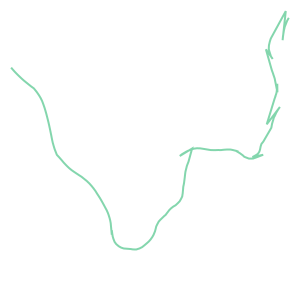

In [60]:
traffic[5]